# Reuters 딥러닝 모델

로이터 뉴스 기사 데이터셋
- 8982개의 훈련 데이터셋과 2246개의 테스트 데이터셋으로 구분
- 뉴스 기사의 주제로 46개 레이블

## 데이터 로드 및 전처리
- reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리
    - 데이터셋은 keras.datasets에서 불러올 수 있는 reuters 데이터 셋을 활용
    - 이때 파라메터 조정을 통해 단어의 개수는 10000개로 제한(num_words=10000).
- 데이터셋 분리 작업에서는 sklearn 라이브러리의 train_test_split 함수를 활용
- 훈련, 검증, 테스트 데이터와 레이블 종류가 몇개인지 출력

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

### 데이터셋 로드

In [2]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# 데이터셋 크기 확인
print(len(train_data))
print(len(test_data))

8982
2246


### 훈련 데이터에서 25%를 검증 데이터셋으로 분리

In [3]:
from sklearn.model_selection import train_test_split

train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, 
                                                                  test_size=0.25, 
                                                                  random_state=42)

In [4]:
# 레이블 종류 확인
num_classes = len(set(train_labels))

# 데이터셋 정보 출력
print(f"훈련 데이터 크기: {len(train_data)}")
print(f"검증 데이터 크기: {len(val_data)}")
print(f"테스트 데이터 크기: {len(test_data)}")
print(f"레이블 종류: {num_classes}")

훈련 데이터 크기: 6736
검증 데이터 크기: 2246
테스트 데이터 크기: 2246
레이블 종류: 46


### 원-핫 인코딩
텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행(원-핫 인코딩 함수)  
레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환한다.

In [5]:
def one_hot_encoding(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [6]:
x_train = one_hot_encoding(train_data)
x_val = one_hot_encoding(val_data)
x_test = one_hot_encoding(test_data)

#### to_categorical()
레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환한다.

In [7]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(train_labels)
y_val = to_categorical(val_labels)
y_test = to_categorical(test_labels)

## 모델 구성 및 컴파일
BatchNormalization과 Dropout을 적용하여 빠르게 학습하면서 과대적합을 방지하고, 46개의 뉴스 주제를 분류하는 딥러닝 모델 구성

### 모델 구성

In [35]:
model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(10000,)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(46, activation='softmax')
])

### 모델 컴파일

In [37]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 모델 요약 출력

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                320032    
_________________________________________________________________
batch_normalization_4 (Batch (None, 32)                128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 46)               

## 모델 학습

### ModelCheckpoin

In [38]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_filepath = '~/aiffel/aiffel/deep_learning_project'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_accuracy',
                                            mode='max',
                                            save_best_only=True)

### EarlyStopping

In [39]:
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=10,  
                                        mode='min',
                                        restore_best_weights=True)

### 모델 학습

In [40]:
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[model_checkpoint_callback, early_stopping_callback])

Epoch 1/100
14/14 [==============================] - 1s 42ms/step - loss: 3.2101 - accuracy: 0.3092 - val_loss: 3.5705 - val_accuracy: 0.5721
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 1.9023 - accuracy: 0.6176 - val_loss: 3.2599 - val_accuracy: 0.6692
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 1.4093 - accuracy: 0.7218 - val_loss: 3.0097 - val_accuracy: 0.6901
Epoch 4/100
14/14 [==============================] - 0s 16ms/step - loss: 1.1130 - accuracy: 0.7794 - val_loss: 2.8177 - val_accuracy: 0.7084
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.9140 - accuracy: 0.8124 - val_loss: 2.6223 - val_accuracy: 0.7199
Epoch 6/100
14/14 [==============================] - 0s 16ms/step - loss: 0.7723 - accuracy: 0.8416 - val_loss: 2.4680 - val_accuracy: 0.7155
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6494 - accuracy: 0.8719 - val_loss: 2.3035 - val_accuracy: 0.7173
Epoch 

### 시각화

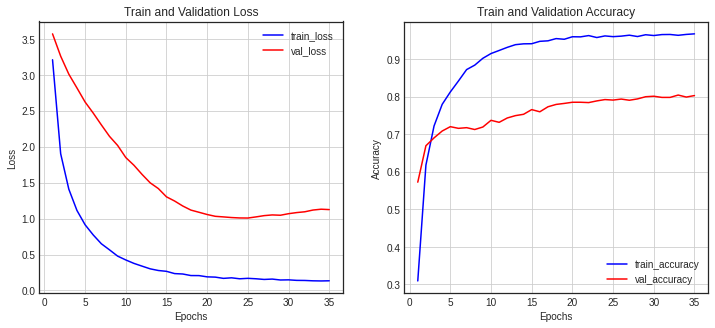

In [41]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

## 모델 평가 및 예측

### 모델 평가

In [42]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

71/71 [==============================] - 0s 3ms/step - loss: 1.0994 - accuracy: 0.7774
Test Loss: 1.099357008934021
Test Accuracy: 0.7773820161819458


### 모델 예측
예측된 클래스는 확률이 가장 높은 인덱스에 해당하므로, argmax를 사용하여 가장 높은 확률의 인덱스를 찾는다.

In [43]:
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# 실제 레이블과 예측 레이블의 비교
print("첫 10개 테스트 샘플에 대한 예측 클래스: ", predicted_classes[:10])
print("첫 10개 테스트 샘플에 대한 실제 클래스: ", test_labels[:10])

첫 10개 테스트 샘플에 대한 예측 클래스:  [ 3 24  1  3 13  3  3  3  3  3]
첫 10개 테스트 샘플에 대한 실제 클래스:  [ 3 10  1  4  4  3  3  3  3  3]


### 시각화

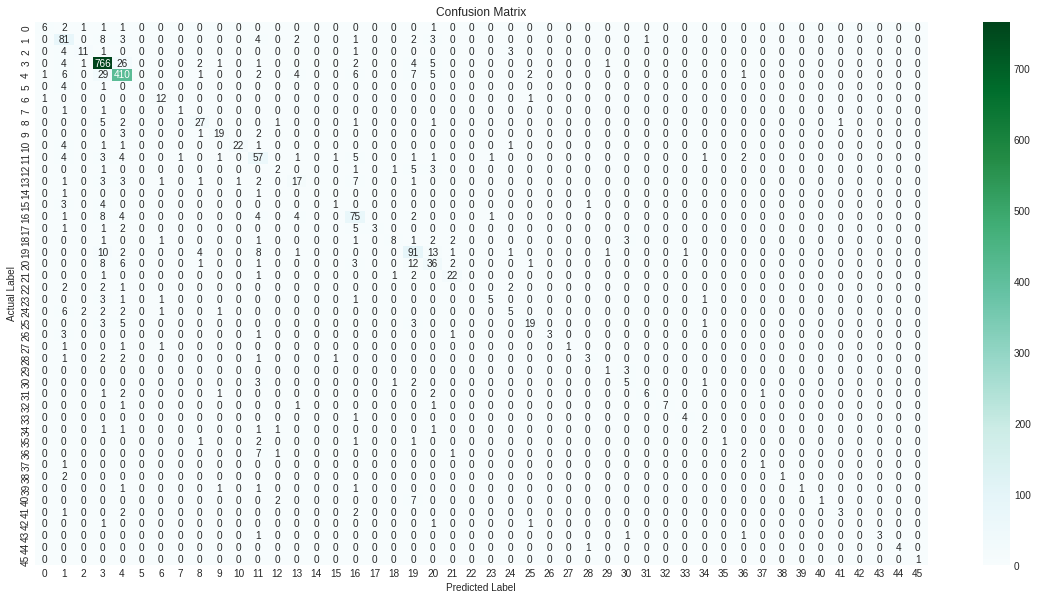

In [44]:
# 혼동행렬 
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(test_labels, predicted_classes)

plt.figure(figsize=(20,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="BuGn")
plt.title("Confusion Matrix")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [45]:
# 분류 리포트 
print("Classification Report:\n", classification_report(test_labels, predicted_classes, target_names=[f"Class {i}" for i in range(num_classes)]))

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.75      0.50      0.60        12
     Class 1       0.60      0.77      0.68       105
     Class 2       0.73      0.55      0.63        20
     Class 3       0.88      0.94      0.91       813
     Class 4       0.84      0.86      0.85       474
     Class 5       0.00      0.00      0.00         5
     Class 6       0.71      0.86      0.77        14
     Class 7       0.50      0.33      0.40         3
     Class 8       0.71      0.71      0.71        38
     Class 9       0.79      0.76      0.78        25
    Class 10       0.96      0.73      0.83        30
    Class 11       0.56      0.69      0.62        83
    Class 12       0.29      0.15      0.20        13
    Class 13       0.57      0.46      0.51        37
    Class 14       0.00      0.00      0.00         2
    Class 15       0.33      0.11      0.17         9
    Class 16       0.66      0.76      0.70        99
   

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 결과
Test Loss: 1.099357008934021  
테스트 데이터셋에 대한 손실 값이 1.099라는 것은 모델이 일부 오류를 범하고 있음을 나타낸다.


Test Accuracy: 0.7773820161819458
모델의 테스트 정확도가 약 77.74%라는 것은 모델이 테스트 데이터셋의 약 78%를 정확하게 분류했다는 것을 의미한다.  
이는 상당히 높은 정확도이며, 모델이 다양한 뉴스 기사의 주제를 잘 구별해내고 있음을 보여준다.  


해석
모델은 전체적으로 좋은 성능을 보이고 있으며, 다수의 뉴스 기사를 올바른 카테고리로 분류할 수 있다.   
그러나 여전히 약 22%의 기사는 잘못 분류되고 있는데, 이는 모델이 특정 기사의 주제를 정확하게 파악하지 못하거나,  
데이터셋의 일부 주제 간 구분이 명확하지 않을 수 있음을 시사한다.